# In this part, we extracted semantic regions and claculated some stastical measure and saved as a csv file. Our raw data are 4 classes of image: Cow, Car, House, Tree. We label them [Cow, Car, House, Tree] = [1,2,3,4] and other regions as 0. 


In [27]:
import os
import numpy as np
from matplotlib import pyplot as plt
import math
from scipy import ndimage
from scipy.stats import skew
from scipy.stats import moment
import copy 

In [28]:
def get_main_colors(img):
    number_of_bin = 3
    bin_dividor = math.ceil(256 / number_of_bin)
    r,c,z = img.shape
    numer_of_pixels = r*c
    sum_of_bins = np.asarray([[0]*3]*(number_of_bin * number_of_bin * number_of_bin))
    count_bin_element = np.asarray([0]*(number_of_bin * number_of_bin * number_of_bin))
  
    for row in img:
        for pixel in row:
            x = int((pixel[0] / bin_dividor)) * (number_of_bin * number_of_bin) \
            + int((pixel[1] / bin_dividor)) * number_of_bin \
            + int((pixel[2] / bin_dividor))
            count_bin_element[x] += 1
            sum_of_bins[x][0] += pixel[0]
            sum_of_bins[x][1] += pixel[1]
            sum_of_bins[x][2] += pixel[2]

    main_colors = []
    for i in range(0, number_of_bin * number_of_bin * number_of_bin):
        if count_bin_element[i] / numer_of_pixels > 0.05:
            main_colors.append(
                [
                    int(sum_of_bins[i][0] / count_bin_element[i]),
                    int(sum_of_bins[i][1] / count_bin_element[i]),
                    int(sum_of_bins[i][2] / count_bin_element[i]),
                ]
            )
    return main_colors

In [29]:
def data_cost(pixel, main_colors):
    colors_sum = 0
    color_sum_list = []
    for color in main_colors:
        color_sum = pow(
            pow(pixel[0] - color[0], 2)
            + pow(pixel[1] - color[1], 2)
            + pow(pixel[2] - color[2], 2),
            0.5)
        color_sum_list.append(color_sum)
        colors_sum += color_sum
    
    color_cost_list = []
    for c_cost in color_sum_list:
        try:
            color_cost_list.append(-math.log(1.0 - float(c_cost/colors_sum)))
        except:
            color_cost_list.append(0)
    return color_cost_list


In [30]:
def show_plot(img):
    plt.imshow(img, interpolation="none")
    plt.show()

In [31]:
def pixel_labeling(pixel, main_colors):
    
    for x in range(pixel.shape[0]):
        for y in range(pixel.shape[1]):
            costs = data_cost(pixel[x][y].color, main_colors)
            m_color_cost = min(costs)
            m_color_index = costs.index(m_color_cost)
            pixel[x][y].label = main_colors[m_color_index]
            pixel[x][y].cost = m_color_cost
            for i in range(len(main_colors)):
                pixel[x][y].color_cost[str(main_colors[i])] = costs[i]
                
    return pixel
    

In [32]:
def get_neighbour_indices(x, y, x_max, y_max):
    n = []
    if x > 0:
        n.append([x - 1, y])
    if x < x_max:
        n.append([x + 1, y])
    if y > 0:
        n.append([x, y - 1])
    if y < y_max:
        n.append([x, y + 1])
    return n

In [33]:
def smooth_cost_expansion(pixels, pos, color):
    neighbour = get_neighbour_indices(pos[0], pos[1], pixels.shape[0]-1, pixels.shape[1]-1)
    epsilon = 3
    smooth_cost = 0
    for n in neighbour:
        if pixels[n[0]][n[1]].label == color:
            smooth_cost +=epsilon
    return smooth_cost

In [34]:
def clusters_grid(pixels, main_colors):
    clusters = []
    cluster_colors = []
    for color in main_colors:
        clusteredPixel = []       
        for x in range(pixels.shape[0]):
            for y in range(pixels.shape[1]):
                if pixels[x][y].label == color:
                    clusteredPixel.append([x, y])
        if len(clusteredPixel) > 0:
            clusters.append(clusteredPixel)
            cluster_colors.append(color)
    
    return clusters, cluster_colors

In [35]:
def color_clusters(pixels, main_colors):
    clusters = []
    cluster_colors = []
    for color in main_colors:
        clusteredPixel = []       
        for x in range(pixels.shape[0]):
            for y in range(pixels.shape[1]):
                if pixels[x][y].label == color:
                    clusteredPixel.append(pixels[x][y].color)
        if len(clusteredPixel) > 0:
            clusters.append(clusteredPixel)
            cluster_colors.append(color)
    
    return clusters, cluster_colors

In [36]:
def svm_input(main_colors, pixels):
    
    cluster, cluster_colors = color_clusters(pixels, main_colors)
    img_seg_info = []
    for cl in cluster:
        cl_mean = np.mean(cl, axis=0)
        cl_var = np.var(cl, axis=0)
        cl_ske = skew(cl, axis=0)
        cl_moment = moment(cl, axis=0)
        img_seg_info.append([cl_mean, np.sqrt(cl_var), cl_ske, cl_moment])
    
    return np.array(img_seg_info), cluster_colors

In [37]:
def fast_alpha_expansion(pixels, clusters, color, clusterChanges):
    changeDuringIteration = False
    for i in range(len(clusters)):
        if set(pixels[clusters[i][0][0]][clusters[i][0][1]].label) != set(color):
            colorCost = 0
            for pos in clusters[i]:
                colorCost += (pixels[pos[0]][pos[1]].cost- pixels[pos[0]][pos[1]].color_cost[str(color)])
                colorCost += smooth_cost_expansion(pixels, [pos[0], pos[1]], color)

            if colorCost > clusterChanges[i][0]:
                changeDuringIteration = True
                clusterChanges[i][0] = colorCost
                clusterChanges[i][1] = color
    return [changeDuringIteration, clusterChanges]

In [38]:
def remove_erosion (pixels, nPixel, main_colors):
    for color in main_colors:
        bPixel = [[None for y in range(pixels.shape[1] )] for x in range(pixels.shape[0])]
        for z in range(0, pixels.shape[0]):
            for j in range(0, pixels.shape[1]):
                if set(nPixel[z][j]) == set(color):
                    bPixel[z][j] = 1
                else:
                    bPixel[z][j] = 0
        bPixel = ndimage.binary_closing(bPixel)
        for z in range(0, pixels.shape[0] ):
            for j in range(0, pixels.shape[1]):
                if bPixel[z][j] == 1:
                    nPixel[z][j] = color
                    pixels[z][j].label = color
    return nPixel

In [39]:
class Pixel:
    label = None;
    cost = None;
    def __init__(self, color, x, y):
        self.color = color
        self.x = x
        self.y = y
        self.color_cost = {}

In [40]:
def auto_segment(img):
    # Plot original image
    show_plot(img)

    # Get main colors
    iar = np.asarray(img)
    main_colors = get_main_colors(iar)
#     print(main_colors)

    # Creatie each pixel as a object
    pixels = np.array([ [ Pixel(iar[x][y], x ,y ) for y in range(iar.shape[1] - 1) ] for x in range(iar.shape[0] - 1) ])
    pixel_labeling(pixels, main_colors)
    
    nPixel = np.array([ [ pixels[x][y].label for y in range(pixels.shape[1]) ] for x in range(pixels.shape[0]) ])
    nPixel = remove_erosion(pixels, nPixel, main_colors)
 ######## Start Interation for Fast Alpfa Expansion #########################################
    iteration = True
    new_cluster_colors = []
    used_color = []
    while iteration:
        change_pixel_label = []
        clusters, cl_colors = clusters_grid(pixels, main_colors)
        new_cluster_colors = cl_colors;
        main_colors = cl_colors;
        if len(clusters) <= 2:
            break
        for i in range(len(clusters)):
            change_pixel_label.append([0.0, None, i])
        iteration = False
        for main_color in cl_colors:
            change = fast_alpha_expansion(pixels, clusters, main_color, change_pixel_label)
            if change[0]:
                iteration = True
                change_pixel_label = change[1]

        change_pixel_label.sort(reverse=True)
        changed_color = change_pixel_label[0][1]
        if changed_color != None:
            changed_color_idx = cl_colors.index(changed_color)
            index = change_pixel_label[0][2]
            col = cl_colors[index]
            for pos in clusters[changed_color_idx]:
                pixels[pos[0]][pos[1]].label = col
                pixels[pos[0]][pos[1]].cost = pixels[pos[0]][pos[1]].color_cost[str(col)]
                
        nPixel = np.array([ [ pixels[x][y].label for y in range(pixels.shape[1]) ] for x in range(pixels.shape[0]) ])
        ## remove erosion
        nPixel = remove_erosion(pixels, nPixel, cl_colors)
#         show_plot(nPixel)
        if len(main_colors) == 2:
            break
                    
    segment_info, cluster_colors = svm_input(new_cluster_colors, pixels)
    inp = 0
    for cluster_color in cluster_colors:
        bPixel = [[None for y in range(iar.shape[1] - 1)] for x in range(iar.shape[0] - 1)]
        for x in range(0, iar.shape[0] - 1):
            for y in range(0, iar.shape[1] - 1):
                if set(nPixel[x][y]) == set(cluster_color):
                    bPixel[x][y] = pixels[x][y].color
                else:
                    bPixel[x][y] = [0, 0, 0]
        print("segment: {} and info {} ".format(inp, segment_info[inp]))
        show_plot(np.array(bPixel))
        inp+=1
    
    return segment_info

In [44]:
## For cow= 1, car = 2, house = 3, tree = 4
dir0 = os.path.abspath('.')
nd0 = dir0+'/data_image/cow'
label_list0 = os.listdir(nd0) 
image_list0 = [nd0+'/'+dir for dir in os.listdir(nd0)]
# image_list0
# dir0
nd1 = dir0+'/data_image/tree'
label_list1 = os.listdir(nd1) 
image_list1 = [nd1+'/'+dir for dir in os.listdir(nd1)]

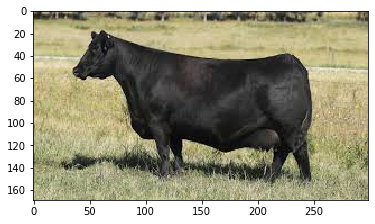

segment: 0 and info [[49.54042972 48.86507025 45.43524138]
 [22.49878273 22.28754658 21.04957433]
 [ 0.8517582   0.89035559  0.58386488]
 [ 0.          0.          0.        ]] 


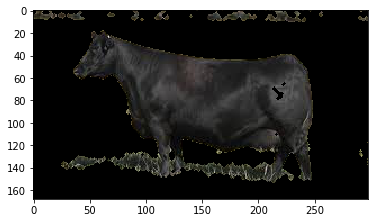

segment: 1 and info [[178.40908948 172.69508702 129.37226576]
 [ 27.97366509  25.23657118  23.0477937 ]
 [ -0.83172596  -0.9550995   -0.40709379]
 [  0.           0.           0.        ]] 


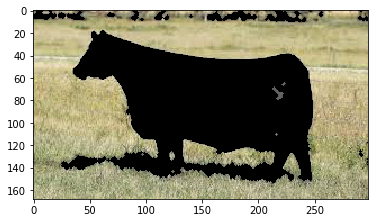

array([[[ 49.54042972,  48.86507025,  45.43524138],
        [ 22.49878273,  22.28754658,  21.04957433],
        [  0.8517582 ,   0.89035559,   0.58386488],
        [  0.        ,   0.        ,   0.        ]],

       [[178.40908948, 172.69508702, 129.37226576],
        [ 27.97366509,  25.23657118,  23.0477937 ],
        [ -0.83172596,  -0.9550995 ,  -0.40709379],
        [  0.        ,   0.        ,   0.        ]]])

In [45]:
auto_segment(plt.imread(image_list0[12]))

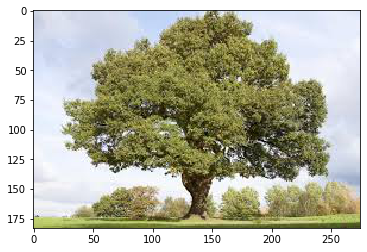

segment: 0 and info [[ 1.24849229e+02  1.22174548e+02  7.49858007e+01]
 [ 4.39469454e+01  4.44667141e+01  4.28660135e+01]
 [-1.21780771e-01 -9.20299101e-02  5.90101213e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]] 


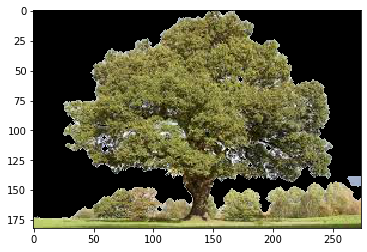

segment: 1 and info [[223.92523742 229.34628208 241.46665993]
 [ 15.77572109  13.57738133  13.65021239]
 [ -0.81987838  -1.12192099  -2.64428393]
 [  0.           0.           0.        ]] 


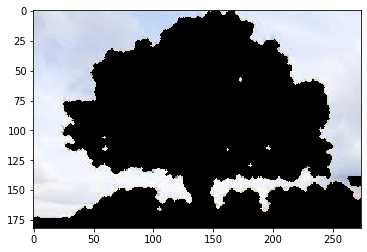

array([[[ 1.24849229e+02,  1.22174548e+02,  7.49858007e+01],
        [ 4.39469454e+01,  4.44667141e+01,  4.28660135e+01],
        [-1.21780771e-01, -9.20299101e-02,  5.90101213e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 2.23925237e+02,  2.29346282e+02,  2.41466660e+02],
        [ 1.57757211e+01,  1.35773813e+01,  1.36502124e+01],
        [-8.19878377e-01, -1.12192099e+00, -2.64428393e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]])

In [46]:
auto_segment(plt.imread(image_list1[20]))

In [47]:
def features_extration(img, label):
    feature_list = []
    i = 0
    for seg in img:
        feature_list0 = []
        for rgb in seg:
            for c in rgb:
                feature_list0.append(c)
        feature_list0.append(label[i])
        i+=1
        feature_list.append(feature_list0)     
        
    return feature_list

In [48]:
dir = os.path.abspath('.')
nd_cow = dir+'/data_image/cow'
nd_car = dir+'/data_image/car'
nd_house = dir+'/data_image/house'
nd_tree = dir+'/data_image/tree'
L = [1,2,3,4]
im_lists = [nd_cow, nd_car, nd_house, nd_tree]
csv_list = ['data_cow.csv', 'data_car.csv', 'data_house.csv', 'data_tree.csv']
image_lists = []
for nd in im_lists:
    im_list = os.listdir(nd) 
    image_list = [nd+'/'+dir for dir in os.listdir(nd)]
    image_lists.append(image_list)
# print(len(image_lists[1]))

In [51]:
import csv
for xx in range(len(L)):
    train_data = []
    print(' ')
    i = 0
    for im in image_lists[xx]:
        print("Image No:", i)
        seginf = auto_segment(plt.imread(im))
        if (len(seginf) == 1):
            label = [L[xx]]
        if (len(seginf) == 2):
            label = [L[xx], 0]
        if (len(seginf) == 3):
            label = [L[xx], 0, 0]
        feature = features_extration(seginf, label)
        train_data.append(feature)
        i+=1
    with open(csv_list[xx], mode='w', newline='') as data_write:
        train_data_writer = csv.writer(data_write, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        for d0 in train_data:
            for d1 in d0:
                train_data_writer.writerow(d1)

    